## I. Perkenalan
--- 
### Gambaran Besar Dataset
Dataset ini berisi pengamatan cuaca harian dari beberapa lokasi di Australia selama sekitar 10 tahun (dari tahun 2007 - 2017).  
RainTomorrow adalah variabel target untuk diprediksi, artinya apakah hari berikutnya hujan, Ya atau Tidak? Ya jika hujan > 1mm  

Arti setiap kolom [Column Meaning](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)


### Objektif
Memprediksi hujan di hari berikutnya dengan melatih model klasifikasi pada variabel target RainTomorrow.


## II. Import Pustaka
---

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

import random
from collections import Counter

## III. Data Loading
---

In [7]:
data_raw = pd.read_csv('data/weatherAUS.csv')
pd.set_option("display.max_columns", None) # untuk menampilkan semua kolom
data_raw.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [9]:
data_raw.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [10]:
data_raw.shape

(145460, 23)

In [11]:
data_raw[data_raw.duplicated()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


## IV. Data Cleaning
---

### Missing Values
Terlihat tidak ada data yang duplikat namun banyak terdapat *missing value* di hampir semua kolom (hanya kolom `Date` dan `Location` yang tidak ada missing value). Untuk missing value di kolom `RainTommorrow` yang merupakan target akan saya drop barisnya karena hanya 3,267 data yang missing, jika dilakukan **data imputation** mungkin dapat menyebabkan bias.  

Yang akan saya lakukan:
- Pertama saya akan melakukan pengecekan persentase *missing value*, untuk kolom yang memiliki *missing value* >= 30% akan saya drop
- Untuk kolom target `RainTommorow`, baris yang memiliki missing value akan di drop
- Selanjutnya semua proses yang disebutkan di bawah akan dilakukan pada bagian Data Preprocessing
- Data akan saya split menjadi *training set* dan *test set*
- Kemudian saya akan lakukan adalah melakukan data imputation untuk kolom-kolom feature
- Untuk data merupakan numerik akan saya lakukan data imputation menggunakan nilai *median*  
- Untuk data kategorik akan diisi dengan *most frequesnt* 

In [12]:
data = data_raw.copy()

In [13]:
pd.DataFrame({
    'Missing Value': (data.isnull().mean())
})

,Missing Value
Date,0.000000
Location,0.000000
MinTemp,0.010209
MaxTemp,0.008669
Rainfall,0.022419
Evaporation,0.431665
Sunshine,0.480098
WindGustDir,0.070989
WindGustSpeed,0.070555
WindDir9am,0.072639


In [14]:
# drop kolom feature dengan persen data hilang >= 30%
for i in data.columns.to_list():
    if data[i].isnull().mean() >= 0.3:
        print(f"Kolom {i} dengan persen data hilang = {(data[i].isnull().mean()):.3%} di drop")
        data.drop([i], axis=1, inplace=True)
data.columns

Kolom Evaporation dengan persen data hilang = 43.167% di drop
Kolom Sunshine dengan persen data hilang = 48.010% di drop
Kolom Cloud9am dengan persen data hilang = 38.422% di drop
Kolom Cloud3pm dengan persen data hilang = 40.807% di drop


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [15]:
# drop baris yang memiliki missing value di kolom target `RainTomorrow`
data.dropna(subset=['RainTomorrow'], inplace=True)

## V. Eksplorasi Data
---

In [16]:
location = data.Location.unique() # list semua lokasi

cat_data = [col for col in data.columns if data[col].dtype == 'O'] # list kolom-kolom kategorik
num_data = [col for col in data.columns if data[col].dtype != 'O'] # list kolom-kolom numerik
print(f'List kolom-kolom kategorik:\n{cat_data}\n')
print(f'List kolom-kolom numerik:\n{num_data}')

List kolom-kolom kategorik:
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

List kolom-kolom numerik:
['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


Cek distribusi kategori di kolom target `RainTomorrow`

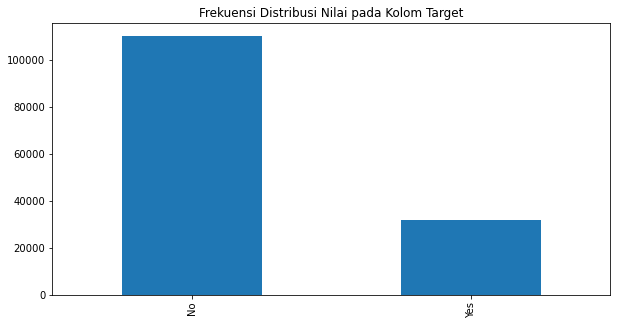

In [17]:
plt.figure(figsize=(10, 5))
data['RainTomorrow'].value_counts().plot(kind='bar')
plt.title('Frekuensi Distribusi Nilai pada Kolom Target')
plt.show()

In [18]:
dist_RT = data['RainTomorrow'].value_counts(dropna=False)

print(f'''
Frekuensi distribusi dari value kolom target `RainTomorrow`:
1. Sebanyak {dist_RT[0]:,} adalah {dist_RT.index[0]}
2. Sebanyak {dist_RT[1]:,} adalah {dist_RT.index[1]}

Kategori No jauh lebih banyak daripada kategori Yes, di mana kategori No sekitar 3.5 kali lebih banyak
''')



Frekuensi distribusi dari value kolom target `RainTomorrow`:
1. Sebanyak 110,316 adalah No
2. Sebanyak 31,877 adalah Yes

Kategori No jauh lebih banyak daripada kategori Yes, di mana kategori No sekitar 3.5 kali lebih banyak



### Cardinality

In [19]:
for i in cat_data:
    count = data[i].nunique()
    print(f'Kardinalitas kolom {i} adalah {count}')

Kardinalitas kolom Date adalah 3436
Kardinalitas kolom Location adalah 49
Kardinalitas kolom WindGustDir adalah 16
Kardinalitas kolom WindDir9am adalah 16
Kardinalitas kolom WindDir3pm adalah 16
Kardinalitas kolom RainToday adalah 2
Kardinalitas kolom RainTomorrow adalah 2


Kolom `Date` memiliki unique value yang terlalu banyak. Untuk mengatasinya saya akan memisah kolom `Date` menjadi 3 kolom yaitu kolom `Day`, `Month` dan `Year` dan untuk kolom lainnya akan dilakukan *one-hot-encoding / label encoding* di bagian **Data Preprocessing**.

In [20]:
data.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,142193,142193,132863,132180,138415,140787,142193
unique,3436,49,16,16,16,2,2
top,2016-07-07,Canberra,W,N,SE,No,No
freq,49,3418,9780,11393,10663,109332,110316


### Boxplot untuk Data Numerik

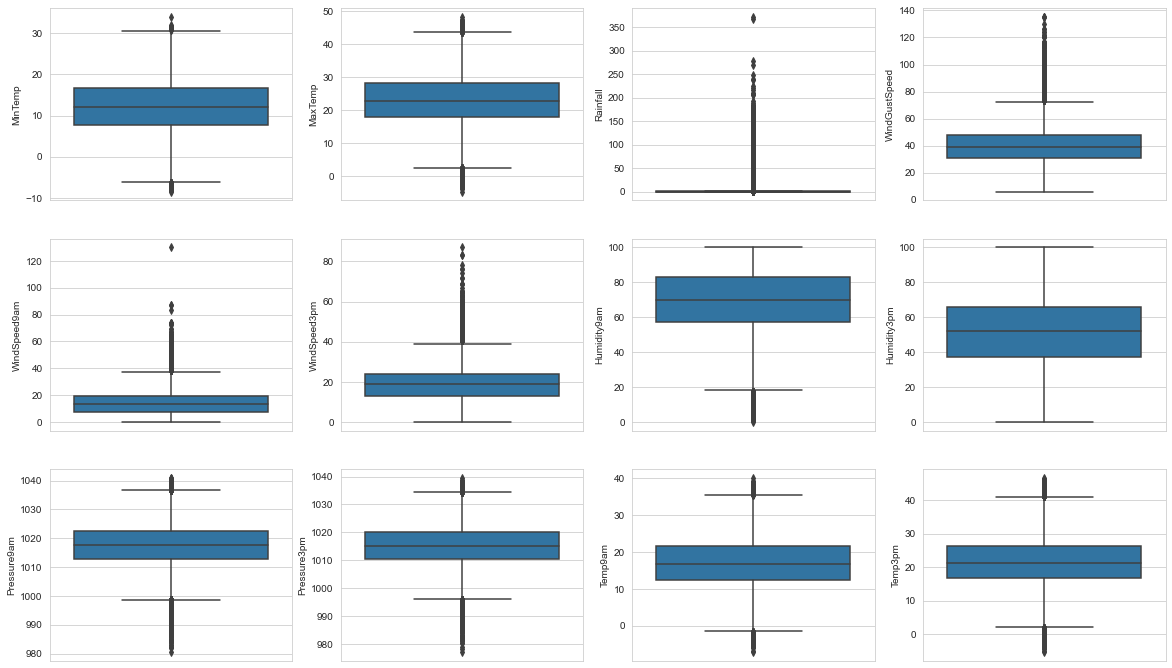

In [21]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))

idx_num = 0
for row in range(3):
    for col in range(4):
        sns.boxplot(data=data, y = num_data[idx_num], ax = axes[row,col])
        idx_num += 1
    

In [22]:
data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,16.987509,21.687235
std,6.403283,7.117618,8.465173,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


Jika dilihat dari boxplot terlihat semua kecuali feature `Humidity3pm` memiliki outlier. Jika dilihat beberapa feature seperti:
1. `MinTemp` --> Temperatur minimum pada satu hari dalam derajat Celcius (min: -8.5, max: 33.9)
2. `MaxTemp` --> Temperatur minimum pada satu hari dalam derajat Celcius (min: -4.8, max: 48.1)  
Temperatur masih di dalam range temperatur tercatat di Australia di mana yang terendah $-23^{O}C$ sampai $50.7^{O}C$    
<br>

3. `Rainfall` --> Volume hujan dalam satuan milimeter (min: 0, max: 371)  
Nilai 0 berarti pada hari tersebut tidak hujan. Secara keseluruhan curah hujan Australia di kisaran rata-rata rendah, jadi masuk akal jika sebagian besar data rainfall adalah 0. Di mana area yang paling kering bisa hanya mendapat hujan 125mm per tahun  
<br>

dan lain sebagainya.  
Intinya, suatu lokasi bisa saja sewaktu-waktu mengalami cuaca ekstrem yang dapat menyebabkan seakan-akan ada outlier pada boxplot di atas. Pada hal data-data "outlier" ini sangat mungkin adalah data nyata. Maka dalam hal ini outlier yang ada tidak akan di hapus.

[sumber](https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/climatic-extremes)

## VI. Data Preprocessing
---

### Mengatasi Cardinality di kolom `Date`

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

data.drop(columns=['Date'], inplace = True)
data.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month,Year
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,1,12,2008
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,2,12,2008
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,3,12,2008
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,4,12,2008
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,5,12,2008


### Feature Selection

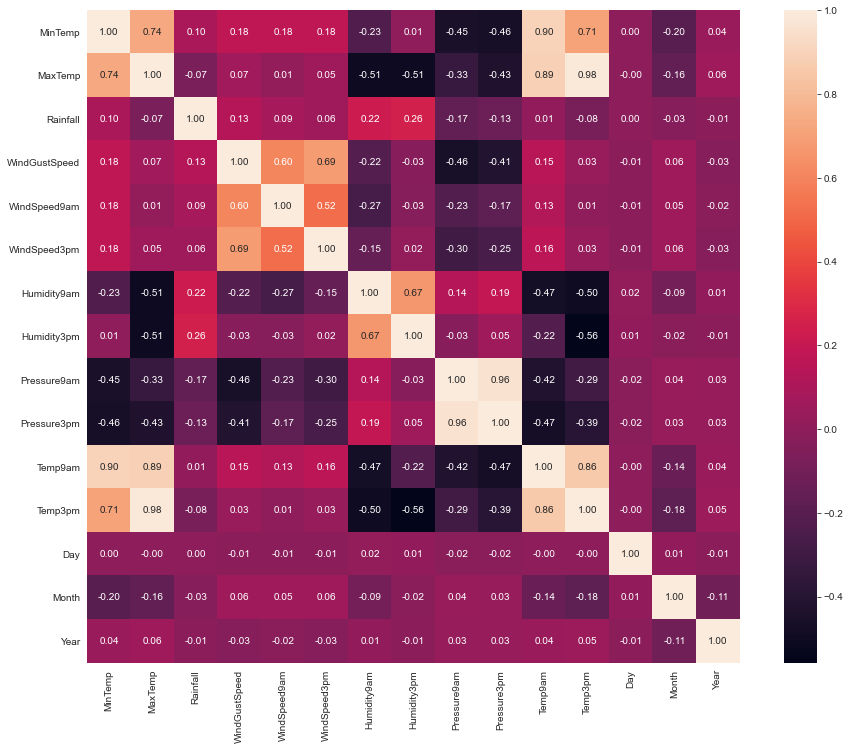

In [25]:
corr = data.corr()
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr, square=True, annot=True, fmt='.2f', linecolor='white')
plt.show()

Dari heatmap di atas, ada beberapa feature yang memiliki korelasi yang tinggi:
- `MinTemp` dan `MaxTemp` saling berkorelasi positif dengan nilai **0.74**
- `MinTemp` dan `Temp9am` saling berkorelasi positif dengan nilai **0.90**
- `MinTemp` dan `Temp3pm` saling berkorelasi positif dengan nilai **0.71**
- `MaxTemp` dan `Temp9am` saling berkorelasi positif dengan nilai **0.89**
- `MaxTemp` dan `Temp3pm` saling berkorelasi positif dengan nilai **0.98**
- `WindGustSpeed` dan `WindSpeed3am` saling berkorelasi positif dengan nilai **0.69**
- `Pressure9am` dan `Pressure3pm` saling berkorelasi positif dengan nilai **0.96**
- `Temp9am` dan `Temp3pm` saling berkorelasi positif dengan nilai **0.86**

In [27]:
drop_numvar = ['MinTemp', 'MaxTemp', 'Temp3pm', 'WindGustSpeed', 'Pressure3pm']
data.drop(drop_numvar, axis=1, inplace=True)

### Split Data

In [29]:
X = data.drop('RainTomorrow', axis = 1)
y = data.RainTomorrow

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = 42)

### Pipeline

In [31]:
cat_feature = [col for col in data.columns if data[col].dtype == 'O'] # list kolom-kolom kategorik
cat_feature.remove('RainTomorrow')
num_feature = [col for col in data.columns if data[col].dtype != 'O'] # list kolom-kolom numerik

In [32]:
# numerik pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Handling missing values
    ('scaling', StandardScaler()) # Penyekalaan data
])

In [33]:
# kategorik pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(sparse=False)),
    ('scaling', StandardScaler())
])

In [34]:
# master pipeline untuk preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipeline, num_feature), 
    ('categorical', cat_pipeline, cat_feature)
])

## VII. Pendefinisian Model
---

In [35]:
# Logistic Regression
pipeline_log = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

In [36]:
pipeline_svm = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC())
])

## VIII. Pelatihan Model
---

In [37]:
pipeline_log.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Rainfall', 'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Day', 'Month', 'Year']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                            

In [38]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Rainfall', 'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Temp9am',
                                                   'Day', 'Month', 'Year']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                            

## IX. Evaluasi Model
---

### Baseline Model

#### 1. Logistic Regression

In [41]:
y_pred = pipeline_log.predict(X_test)
print(classification_report(y_test, pipeline_log.predict(X_test)))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

          No       0.86      0.95      0.90     22064
         Yes       0.71      0.46      0.56      6375

    accuracy                           0.84     28439
   macro avg       0.79      0.70      0.73     28439
weighted avg       0.83      0.84      0.82     28439

[[20900  3458]
 [ 1164  2917]]


Meskipun akurasi dari model ini 0.84, model ini buruk dalam mendeteksi class `Yes`. Alasannya mungkin karena *imbalanced data* di mana class `No` jauh lebih banyak datanya dari class `Yes` (3.5 kali lebih banyak).

### 2. SVM

In [43]:
y_pred = pipeline_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

          No       0.86      0.96      0.91     22064
         Yes       0.77      0.48      0.59      6375

    accuracy                           0.85     28439
   macro avg       0.82      0.72      0.75     28439
weighted avg       0.84      0.85      0.84     28439

[[21165  3316]
 [  899  3059]]


Model ini memerlukan +-20 menit untuk di fit menggunakan mesin saya. Dibandingkan dengan model sebelumnya, *Logistic Regression*, yang hanya +-2 detik.  
Jika dilihat dari keseluruhan score, score model SVM ini cukup mirip dengan model sebelumnya dan hanya sedikit lebih baik dalam mendeteksi class `No`.

### Parameter Tuning

In [59]:
param_grid_log = {'algo__penalty': ['l1', 'l2','elasticnet', 'none'],
                'algo__C': [0.001, 0.01, 0.1, 1],
                'algo__solver': ['lbfgs', 'sag', 'saga']
}



# param_grid_svm = {
#                 'algo__C': [0.001, 0.01, 0.1, 1],
#                 'algo__kernel': ['rbf', 'linear']
# }

#### 1. Loggistic Regression

In [60]:
rand_log = RandomizedSearchCV(pipeline_log, param_grid_log, cv =5, random_state=42, n_jobs=-1)
rand_log.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaling',
                                                                                                StandardScaler())]),
                                                                               ['Rainfall',
                                                                                'WindSpeed9am',
                                                                                'WindSpeed3pm',
                                                                                'Humi

In [61]:
rand_log.best_params_

{'algo__solver': 'saga', 'algo__penalty': 'l1', 'algo__C': 0.1}

In [62]:
log_best_params = rand_log.best_estimator_

In [63]:
y_pred = log_best_params.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred,y_test))

[[20907  3460]
 [ 1157  2915]]
              precision    recall  f1-score   support

          No       0.95      0.86      0.90     24367
         Yes       0.46      0.72      0.56      4072

    accuracy                           0.84     28439
   macro avg       0.70      0.79      0.73     28439
weighted avg       0.88      0.84      0.85     28439



#### 2. SVM

Tidak dilakukan parameter tuning menggunakan RandomizedSearchCV untuk yang SVM karena dataset training terlalu banyak dan akan memakan waktu yang terlalu lama

In [ ]:
# rand_svm = RandomizedSearchCV(pipeline_svm, param_grid_svm, cv =5, random_state=42, n_jobs=4)
# rand_svm.fit(X_train, y_train)

In [ ]:
# svm_best_params = rand_log.best_estimator_

In [ ]:
# y_pred = svm_best_params.predict(X_test)
# print(confusion_matrix(y_pred, y_test))
# print(classification_report(y_pred,y_test))

## X. Model Inference
---

### Create new dataset with 100 rows

In [50]:
# list of possible categorical value
Location = data['Location'].unique()
WindGustDir = data['WindGustDir'].unique()
WindDir9am = data['WindDir9am'].unique()
WindDir3pm = data['WindDir3pm'].unique()
RainToday = data['RainToday'].unique()

# empty list for new value
new_Location = []
new_Rainfall = []
new_WindGustDir = []
new_WindDir9am = []
new_WindDir3pm = []
new_WindSpeed9am = []
new_WindSpeed3pm = []
new_Humidity9am = []
new_Humidity3pm = []
new_Pressure9am = []
new_Temp9am = []
new_RainToday = []
new_Day = []
new_Month = []
new_Year = []

#fill new list with random values from list of possible values 100 times
for i in range(100):
    Rainfall = round(random.uniform(0.00, 400.00), 2)
    WindSpeed9am = round(random.uniform(0.00, 150.00), 2)
    WindSpeed3pm = round(random.uniform(0.00, 100.00), 2)
    Humidity9am = round(random.uniform(0.00, 100.00), 2)
    Humidity3pm = round(random.uniform(0.00, 100.00), 2)
    Pressure9am = round(random.uniform(800.00, 1200.00), 2)
    Temp9am = round(random.uniform(-10.00, 55.00), 2)
    Day = round(random.uniform(1, 31), 0)
    Month = round(random.uniform(1, 12), 0)
    Year = round(random.uniform(2017, 2021), 0)


    new_Location.append(random.choice(Location))
    new_WindGustDir.append(random.choice(WindGustDir))
    new_WindDir9am.append(random.choice(WindDir9am))
    new_WindDir3pm.append(random.choice(WindDir3pm))
    new_RainToday.append(random.choice(RainToday))

    new_Rainfall.append(Rainfall)
    new_WindSpeed9am.append(WindSpeed9am)
    new_WindSpeed3pm.append(WindSpeed3pm)
    new_Humidity9am.append(Humidity9am)
    new_Humidity3pm.append(Humidity3pm)
    new_Pressure9am.append(Pressure9am)
    new_Temp9am.append(Temp9am)
    new_Day.append(Day)
    new_Month.append(Month)
    new_Year.append(Year)

dict = {
    'Location':new_Location,
    'Rainfall':new_Rainfall,
    'WindGustDir':new_WindGustDir,
    'WindDir9am':new_WindDir9am,
    'WindDir3pm':new_WindDir3pm,
    'WindSpeed9am':new_WindSpeed9am,
    'WindSpeed3pm':new_WindSpeed3pm,
    'Humidity9am':new_Humidity9am,
    'Humidity3pm':new_Humidity3pm,
    'Pressure9am':new_Pressure9am,
    'Temp9am':new_Temp9am,
    'RainToday':new_RainToday,
    'Day':new_Day,
    'Month':new_Month,
    'Year':new_Year
}

#create new_data dataframe
new_data = pd.DataFrame(dict)
new_data.sample(3)

,Location,Rainfall,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Temp9am,RainToday,Day,Month,Year
86,Dartmoor,55.79,NNW,SSW,NNE,42.35,46.25,93.00,58.28,1158.07,-7.15,Yes,2.0,5.0,2018.0
73,SydneyAirport,29.64,E,SSW,S,97.96,32.97,28.15,45.51,911.45,51.08,No,28.0,2.0,2017.0
56,NorahHead,378.19,SSW,SSE,ENE,138.25,13.33,89.60,34.91,1151.31,26.01,Yes,24.0,5.0,2017.0


### Predict

In [56]:
# Logistic Regression
result_log = pipeline_log.predict(new_data)
Counter(result_log)

Counter({'Yes': 62, 'No': 38})

In [64]:
# Logistic Regression after tuning
result_log_best = log_best_params.predict(new_data)
Counter(result_log_best)

Counter({'Yes': 62, 'No': 38})

In [57]:
# SVC
result_svm = pipeline_svm.predict(new_data)
Counter(result_svm)

Counter({'Yes': 99, 'No': 1})

## XI. Pengambilan Kesimpulan
---

Model yang digunakan dalam projek ini:
1. Logistic Regression
    - Sebelum Tuning:  
        Accuracy: Test Set Score = 0.84  
        f1-score: Class `No`= 0.90, Class `Yes` = 0.56  
    - Setelah Tuning (Best Param: 'algo__solver': 'saga', 'algo__penalty': 'l1', 'algo__C': 0.1)  
        Accuracy: Test Set Score = 0.84  
        f1-score: Class `No`= 0.90, Class `Yes` = 0.56  
2. SVM
    - Sebelum Tuning:  
        Accuracy: Test Set Score = 0.85  
        f1-score: Class `No`= 0.91, Class `Yes` = 0.59  


Nilai akurasi & f1-score Logistic Regression sebelum dan setelah tuning sama sedangkan SVM menunjukkan nilai yang sedikit lebih baik. Namun karena jumlah dataset training yang cukup besar training dengan model SVM memakan waktu yang sangat lama (+- 20 menit) sedangkan untuk Logistic Regression hanya +- 2 detik.  
  
Semua model menunjukkan nilai f1-score yang buruk dalam memprediksi class `Yes`. Hal ini dapat disebabkan karena *imbalanced* dataset, di mana class`No` 3.5 kali lebih banyak.  
  
#### Future Note
- SVM : jika memungkinkan, lakukan sampling saja agar training model lebih cepat
